In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras
# 设置gpu内存自增长
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.1.0
sys.version_info(major=3, minor=7, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.2
numpy 1.17.0
pandas 1.1.3
sklearn 0.23.2
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


# 1.载入数据

In [2]:
import tensorflow_datasets as tfds
example, info = tfds.load('ted_hrlr_translate/pt_to_en',
                     with_info=True,
                     as_supervised=True)
# for data in datasets.take(5):
#     print(data)
#     print()

In [3]:
train = example['train']
for data in train.take(5):
    print(data)
    print()

(<tf.Tensor: shape=(), dtype=string, numpy=b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'>, <tf.Tensor: shape=(), dtype=string, numpy=b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'>)

(<tf.Tensor: shape=(), dtype=string, numpy=b'mas e se estes fatores fossem ativos ?'>, <tf.Tensor: shape=(), dtype=string, numpy=b'but what if it were active ?'>)

(<tf.Tensor: shape=(), dtype=string, numpy=b'mas eles n\xc3\xa3o tinham a curiosidade de me testar .'>, <tf.Tensor: shape=(), dtype=string, numpy=b"but they did n't test for curiosity .">)

(<tf.Tensor: shape=(), dtype=string, numpy=b'e esta rebeldia consciente \xc3\xa9 a raz\xc3\xa3o pela qual eu , como agn\xc3\xb3stica , posso ainda ter f\xc3\xa9 .'>, <tf.Tensor: shape=(), dtype=string, numpy=b'and this conscious defiance is why i , as an agnostic , can still have faith .'>)

(<tf.Tensor: shape=(), dtype

# 2.数据预处理

In [5]:
import tensorflow_datasets as tfds
# 1、生成tokenizer，
pt_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt,en in train),
    target_vocab_size =2**13
)

en_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt,en in train),
    target_vocab_size =2**13
)

# 1.1 保存生成好的tokenizer
en_tokenizer.save_to_file('./tokenizer/en_tokenizer_new')
pt_tokenizer.save_to_file('./tokenizer/pt_tokenizer_new')

In [4]:
import tensorflow_datasets as tfds

en_tokenizer = tfds.deprecated.text.SubwordTextEncoder.load_from_file('./tokenizer/en_tokenizer_new')
pt_tokenizer = tfds.deprecated.text.SubwordTextEncoder.load_from_file('./tokenizer/en_tokenizer_new')

In [5]:
# 2、用tokenizer将字符串编码成数字
def tokenizer_encoder(pt_sentence, en_sentence):
    pt_sentence = [pt_tokenizer.vocab_size] + pt_tokenizer.encode(pt_sentence.numpy()) + [pt_tokenizer.vocab_size+1]
    en_sentence = [en_tokenizer.vocab_size] + en_tokenizer.encode(en_sentence.numpy()) + [en_tokenizer.vocab_size+1]
    return pt_sentence, en_sentence

def tf_tokenizer_encoder(pt_sentence, en_sentence):
    return tf.py_function(tokenizer_encoder,
                         [pt_sentence,en_sentence],
                         [tf.int64, tf.int64])

# 3、datasets日常操作：filter、shuffle、batch、padding
max_len = 40
batch_size=64
def max_len_filter(pt_sentence, en_sentence):
    return tf.logical_and(tf.size(pt_sentence)<=max_len, tf.size(en_sentence)<=max_len)

train_datasets = train.map(tf_tokenizer_encoder)\
                      .filter(max_len_filter)\
                      .shuffle(buffer_size=20000)\
                      .padded_batch(batch_size=batch_size, padded_shapes=([-1],[-1]))

# for data in train_datasets.take(1):
#     print(data)
#     print()



# 3、搭建模型

In [6]:
def positional_encoding(max_len, d_model):
    pos = np.arange(max_len,dtype=float)[:,np.newaxis]
    dim = np.arange(d_model,dtype=float)[np.newaxis,:]
    matrix = np.multiply(pos, 1 / np.power(10000,2*(dim//2)/np.float32(d_model)))
    matrix[:,::2] = np.sin(matrix[:,::2])
    matrix[:, 1::2] = np.cos(matrix[:, 1::2])
    pos_encoding = np.expand_dims(matrix, 0)
    pos_encoding = tf.cast(pos_encoding,tf.float32)
    return pos_encoding


positional_encoding(2,3)

<tf.Tensor: shape=(1, 2, 3), dtype=float32, numpy=
array([[[0.        , 1.        , 0.        ],
        [0.84147096, 0.5403023 , 0.00215443]]], dtype=float32)>

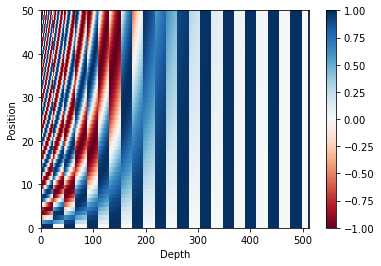

<tf.Tensor: shape=(1, 50, 512), dtype=float32, numpy=
array([[[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
        [ 8.41470957e-01,  5.40302277e-01,  8.21856201e-01, ...,
          1.00000000e+00,  1.03663289e-04,  1.00000000e+00],
        [ 9.09297407e-01, -4.16146845e-01,  9.36414719e-01, ...,
          1.00000000e+00,  2.07326579e-04,  1.00000000e+00],
        ...,
        [ 1.23573124e-01, -9.92335498e-01,  9.77189839e-01, ...,
          9.99987245e-01,  4.87215538e-03,  9.99988139e-01],
        [-7.68254638e-01, -6.40144348e-01,  7.31235921e-01, ...,
          9.99986708e-01,  4.97581763e-03,  9.99987602e-01],
        [-9.53752637e-01,  3.00592542e-01, -1.44026920e-01, ...,
          9.99986112e-01,  5.07947942e-03,  9.99987125e-01]]],
      dtype=float32)>

In [7]:
def plot_position_embedding(position_embedding):
# 绘制位置编码
    plt.pcolormesh(position_embedding[0],cmap='RdBu') # 【50*512】
    plt.xlabel('Depth')
    plt.xlim((0,512))
    plt.ylabel('Position')
    plt.colorbar()
    plt.show()

position_embedding = positional_encoding(50,512)
plot_position_embedding(position_embedding)
position_embedding

In [8]:
def scaled_pot_product_attention(Q,K,V,mask=None):
    QK = tf.matmul(Q,K,transpose_b=True) # shape:(batch_size, heads_num, seq_len, seq_len)
    dk = tf.cast(tf.shape(K)[-1], tf.float32)
    scaled_attention_logits = QK / tf.math.sqrt(dk) # shape:(batch_size, heads_num, seq_len, seq_len)

    if mask is not None:
        scaled_attention_logits += tf.multiply(mask,-1e9) # shape:(batch_size, heads_num, seq_len, seq_len)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) # shape:(batch_size, heads_num, seq_len, seq_len)

    attention_output = tf.matmul(attention_weights, V)  # shape:(batch_size, heads_num, seq_len, depth)
    return attention_output, attention_weights


def FeedForward(dff, d_model):
    return tf.keras.Sequential([
                tf.keras.layers.Dense(units=dff, activation='relu'),
                tf.keras.layers.Dense(d_model),
            ])

def create_padding_mask(input_data):
    padding_mask = tf.cast(tf.math.equal(input_data,0),tf.float32)
    padding_mask = padding_mask[:,tf.newaxis,tf.newaxis,:]
    return padding_mask

def create_look_ahead_mask(input_data):
    '''
    :param input_data: shape:(batch_size, input_seq_len)  input_seq_len包含start跟end
    :return:
    '''
    seq_len = tf.shape(input_data)[1]
    return 1-tf.linalg.band_part(tf.ones((seq_len,seq_len)),-1,0)

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, heads_num):
        super(MultiHeadAttention, self).__init__()
        self.WQ = tf.keras.layers.Dense(units=d_model)
        self.WK = tf.keras.layers.Dense(units=d_model)
        self.WV = tf.keras.layers.Dense(units=d_model)
        self.dense = tf.keras.layers.Dense(d_model)
        self.depth = d_model // heads_num
        self.heads_num = heads_num
        self.d_model = d_model

    def split_head(self, input):
        '''
        :param input: shape: (batch_size, seq_len, d_model)
        :return: shape: (batch_size, heads_num, seq_len, depth)
        '''
        batch_size = tf.shape(input)[0]
        seq_len = tf.shape(input)[1]
        input = tf.reshape(input, (batch_size, seq_len, self.heads_num, self.depth)) # shape:(batch_size, seq_len, heads_num, depth)
        return tf.transpose(input,perm=[0,2,1,3]) # shape:(batch_size, heads_num, seq_len, depth)

    def call(self,q,k,v,padding_mask):
        '''
        :param q:  shape:(batch_size, input_seq_len, d_model)
        :param k:  shape:(batch_size, input_seq_len, d_model)
        :param v:  shape:(batch_size, input_seq_len, d_model)
        :return:   shape:(batch_size, input_seq_len, d_model)    shape:(batch_size, heads_num, seq_len, seq_len)
        '''
        Q = self.WQ(q) # shape:(batch_size, seq_len, d_model)
        K = self.WK(k) # shape:(batch_size, seq_len, d_model)
        V = self.WV(v) # shape:(batch_size, seq_len, d_model)

        Q = self.split_head(Q) # shape:(batch_size, heads_num, seq_len, depth)
        K = self.split_head(K) # shape:(batch_size, heads_num, seq_len, depth)
        V = self.split_head(V) # shape:(batch_size, heads_num, seq_len, depth)

        attention_output, attention_weights = scaled_pot_product_attention(Q,K,V,padding_mask) # shape:(batch_size, heads_num, seq_len, depth)
        attention_output = tf.transpose(attention_output, perm=[0,2,1,3]) # shape:(batch_size, seq_len, heads_num, depth)
        batch_size = tf.shape(q)[0]
        seq_len = tf.shape(q)[1]
        concat_attention = tf.reshape(attention_output, (batch_size, seq_len, self.d_model)) # shape:(batch_size, input_seq_len, d_model)
        output = self.dense(concat_attention) # shape:(batch_size, input_seq_len, d_model)

        return output, attention_weights

def positional_encoding(max_len, d_model):
    pos = np.arange(max_len,dtype=float)[:,np.newaxis]
    dim = np.arange(d_model,dtype=float)[np.newaxis,:]
    matrix = np.multiply(pos, 1 / np.power(10000,2*(dim//2)/np.float32(d_model)))
    matrix[:,::2] = np.sin(matrix[:,::2])
    matrix[:, 1::2] = np.cos(matrix[:, 1::2])
    pos_encoding = np.expand_dims(matrix, 0)
    pos_encoding = tf.cast(pos_encoding,tf.float32)
    return pos_encoding

# *******************************************************************************
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, heads_num, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, heads_num)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.mha2 = MultiHeadAttention(d_model, heads_num)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.ffn = FeedForward(dff, d_model)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        self.layer_norm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, input, encoder_ouput, encoder_decoder_padding_mask, masked_attention_mask, training=False):
        '''
        :param input:          shape:  (batch_size, target_seq_len, d_model)
        :param encoder_ouput:  shape:  (batch_size, input_seq_len, d_model)
        :param encoder_decoder_padding_mask:
        :param masked_attention_mask:
        :return:
        '''
        q = input
        k = input
        v = input
        attn1_output, attn1_weights = self.mha1(q, k, v, masked_attention_mask)  # shape:(batch_size, target_seq_len, d_model)
        attn1_output = self.dropout1(attn1_output,training=training) # shape:(batch_size, input_seq_len, d_model)
        output1 = self.layer_norm1(input + attn1_output) # shape:(batch_size, target_seq_len, d_model)

        q = output1        # shape: (batch_size, target_seq_len, d_model)
        k = encoder_ouput  # shape: (batch_size, input_seq_len, d_model)
        v = encoder_ouput  # shape: (batch_size, input_seq_len, d_model)
        attn2_output, attn2_weights = self.mha2(q, k, v, encoder_decoder_padding_mask)  # shape:(batch_size, target_seq_len, d_model)
        attn2_output = self.dropout2(attn2_output,training=training) # shape:(batch_size, input_seq_len, d_model)
        output2 = self.layer_norm2(output1 + attn2_output) # shape:(batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(output2)  # shape:(batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)  # shape:(batch_size, target_seq_len, d_model)
        output3 = self.layer_norm3(output2 + ffn_output)  # shape:(batch_size, target_seq_len, d_model)

        return output3

class DecoderModel(tf.keras.layers.Layer):
    def __init__(self, target_vocab_size, d_model, max_len, heads_num, dff, layers_num, rate=0.1):
        super(DecoderModel, self).__init__()
        self.d_model = d_model
        self.max_len = max_len
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.decoder_layers = [DecoderLayer(d_model, heads_num, dff, rate) for _ in range(layers_num)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, input, encoder_ouput, encoder_decoder_padding_mask, training=False):
        '''
        :param input:         shape:(batch_size, target_seq_len)  target_seq_len只包含start
        :param encoder_ouput: shape:(batch_size, input_seq_len, d_model)
        :param training:
        :return:
        '''
        decoder_padding_mask = create_padding_mask(input)
        look_ahead_mask = create_look_ahead_mask(input)
        masked_attention_mask = tf.maximum(decoder_padding_mask, look_ahead_mask)

        input_embedding = self.embedding(input) # shape:(batch_size, target_seq_len, d_model)
        input_embedding = input_embedding * tf.math.sqrt(tf.cast(self.d_model,tf.float32)) # shape:(batch_size, target_seq_len, d_model)
        pos_encoding = positional_encoding(self.max_len, self.d_model)  # shape: (1, max_len, d_model)

        input_seq_len = tf.shape(input)[1]
        input_pos_embedding = input_embedding + pos_encoding[:,:input_seq_len,:] # shape:(batch_size, input_seq_len, d_model)
        x = self.dropout(input_pos_embedding, training=training) # shape:(batch_size, input_seq_len, d_model)

        for decoder_layer in self.decoder_layers:
            x = decoder_layer(x, encoder_ouput, encoder_decoder_padding_mask, masked_attention_mask, training=training) # shape:(batch_size, input_seq_len, d_model)
        decoder_ouput = x
        return decoder_ouput # shape:(batch_size, input_seq_len, d_model)
# *******************************************************************************






# *******************************************************************************
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, heads_num, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, heads_num)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.ffn = FeedForward(dff, d_model)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, input, padding_mask, training=False):
        '''
        :param input:  shape: (batch_size, input_seq_len, d_model)
        :param training:
        :return:
        '''
        q = input
        k = input
        v = input
        attn_output, attn_weights = self.mha(q,k,v,padding_mask) # shape:(batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output,training=training) # shape:(batch_size, input_seq_len, d_model)
        output1 = self.layer_norm1(input + attn_output) # shape:(batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(output1) # shape:(batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output,training=training) # shape:(batch_size, input_seq_len, d_model)
        output2 = self.layer_norm2(output1 + ffn_output) # shape:(batch_size, input_seq_len, d_model)

        return output2 # shape:(batch_size, input_seq_len, d_model)

class EncoderModel(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, d_model, max_len, heads_num, dff, layers_num, rate=0.1):
        super(EncoderModel, self).__init__()
        self.d_model = d_model
        self.max_len = max_len
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.encoder_layers = [EncoderLayer(d_model, heads_num, dff, rate) for _ in range(layers_num)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, input, training=False):
        '''
        :param input:  shape:(batch_size, input_seq_len)  input_seq_len包含start跟end
        :param training:
        :return:
        '''
        padding_mask = create_padding_mask(input)

        input_embedding = self.embedding(input) # shape:(batch_size, input_seq_len, d_model)
        input_embedding = input_embedding * tf.math.sqrt(tf.cast(self.d_model,tf.float32)) # shape:(batch_size, input_seq_len, d_model)
        pos_encoding = positional_encoding(self.max_len, self.d_model)  # shape: (1, max_len, d_model)

        input_seq_len = tf.shape(input)[1]
        input_pos_embedding = input_embedding + pos_encoding[:,:input_seq_len,:] # shape:(batch_size, input_seq_len, d_model)
        x = self.dropout(input_pos_embedding, training=training) # shape:(batch_size, input_seq_len, d_model)
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, padding_mask, training=training) # shape:(batch_size, input_seq_len, d_model)
        encoder_ouput = x
        return encoder_ouput, padding_mask # shape:(batch_size, input_seq_len, d_model)

# *******************************************************************************

class Transformer(tf.keras.Model):
    def __init__(self, input_vocab_size, target_vocab_size, d_model, max_len, heads_num, dff, layers_num, rate=0.1):
        super(Transformer, self).__init__()
        self.EncoderModel = EncoderModel(input_vocab_size, d_model, max_len, heads_num, dff, layers_num)
        self.DecoderModel = DecoderModel(target_vocab_size, d_model, max_len, heads_num, dff, layers_num)
        self.linear = tf.keras.layers.Dense(units=target_vocab_size)


    def call(self, encoder_input, decoder_input, training=False):
        '''
        :param encoder_input:  shape:(batch_size, input_seq_len)
        :param decoder_input:  shape:(batch_size, target_seq_len)
        :param training:
        :return:
        '''
        encoder_ouput, encoder_decoder_padding_mask = self.EncoderModel(encoder_input, training=training)
        decoder_ouput = self.DecoderModel(decoder_input, encoder_ouput, encoder_decoder_padding_mask, training=training)
        predictions = self.linear(decoder_ouput) # shape:(batch_size, input_seq_len, d_model)
        predictions = tf.nn.softmax(predictions, axis=-1)
        return predictions # shape: (batch_size, target_seq_len, target_vocab_size)

# 4、模型训练

In [11]:
# **************************************  模型训练   *********************************************
# 1、初始化模型
input_vocab_size = pt_tokenizer.vocab_size + 2
target_vocab_size = en_tokenizer.vocab_size + 2
d_model = 128
max_len = 40
heads_num = 8
dff = 512
layers_num = 4
transformer = Transformer(input_vocab_size, target_vocab_size, d_model, max_len, heads_num, dff, layers_num)

# 2、自定义损失函数
def loss_func(real,pred):
    '''
    :param real: shape:(batch_size, target_seq_len)
    :param pred: shape: (batch_size, target_seq_len, target_vocab_size)
    :return:
    '''
    mask = 1-tf.cast(tf.math.equal(real, 0),tf.float32) # shape: (batch_size, target_seq_len)
    loss_function = tf.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
    loss = loss_function(real,pred) # shape: (batch_size, target_seq_len)
    return tf.reduce_mean(tf.multiply(loss, mask))

# 3、自定义学习率
# lrate = (d_model **-0.5) * min(step_num **-0.5,step_num*warm_up_steps**-1.5) 先增后减的学习率
class CustomizedSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warm_up_steps=4000):
        super(CustomizedSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warm_up_steps = warm_up_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warm_up_steps ** (-1.5))
        arg3 = tf.math.rsqrt(self.d_model)
        return arg3 * tf.math.minimum(arg1, arg2)

# 4、optimizer优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=CustomizedSchedule(d_model))

# 5、定义评估指标
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

# 6、定义好 checkpoint
checkpoint = tf.train.Checkpoint(model=transformer,
                                optimizer=optimizer)

# 7、定义train_step
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]
@tf.function(input_signature=train_step_signature)
def train_step(inp, target):
    tar_inp = target[:,:-1]
    tar_real = target[:,1:]

    with tf.GradientTape() as tape:
        predictions = transformer(inp, tar_inp, training=True)
        loss = loss_func(tar_real, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(tar_real, predictions)


# 8、循环执行训练流程
import time
epoches = 120
for epoch in range(epoches):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    for (batch, (inp, target)) in enumerate(train_datasets):
        train_step(inp,target)
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {} Accuracy {}'.format(epoch+1,batch,train_loss.result(),train_accuracy.result()))
            
    print('Epoch {}  Loss {} Accuracy {}'.format(epoch + 1, train_loss.result(), train_accuracy.result()))
    print('Time take for 1 epoch:{} secs\n'.format(time.time()-start))
    
    if (epoch+1) % 12 == 0:
        path = checkpoint.save(file_prefix='./checkpoint/trf')
        print("**********************    model saved to %s     ************************" % path)
        print()
    


Epoch 1 Batch 0 Loss 4.987122535705566 Accuracy 0.0
Epoch 1 Batch 100 Loss 4.51073694229126 Accuracy 0.026545636355876923
Epoch 1 Batch 200 Loss 4.396350383758545 Accuracy 0.03209593892097473
Epoch 1 Batch 300 Loss 4.210732460021973 Accuracy 0.033920254558324814
Epoch 1 Batch 400 Loss 4.012307167053223 Accuracy 0.03699677065014839
Epoch 1 Batch 500 Loss 3.8417892456054688 Accuracy 0.04503483325242996
Epoch 1  Loss 3.8383219242095947 Accuracy 0.04515818879008293
Time take for 1 epoch:162.11100721359253 secs

Epoch 2 Batch 0 Loss 3.2450525760650635 Accuracy 0.0924479141831398
Epoch 2 Batch 100 Loss 3.040440082550049 Accuracy 0.09694615751504898
Epoch 2 Batch 200 Loss 2.933562755584717 Accuracy 0.10538532584905624
Epoch 2 Batch 300 Loss 2.8364346027374268 Accuracy 0.11202184855937958
Epoch 2 Batch 400 Loss 2.7677245140075684 Accuracy 0.11792724579572678
Epoch 2 Batch 500 Loss 2.6981916427612305 Accuracy 0.12294022738933563
Epoch 2  Loss 2.698106288909912 Accuracy 0.12310423702001572
Time 

Epoch 16 Batch 300 Loss 0.6481584310531616 Accuracy 0.3557683229446411
Epoch 16 Batch 400 Loss 0.6631523966789246 Accuracy 0.354754775762558
Epoch 16 Batch 500 Loss 0.6715425848960876 Accuracy 0.3522303104400635
Epoch 16  Loss 0.6718152761459351 Accuracy 0.3522082567214966
Time take for 1 epoch:143.09844326972961 secs

Epoch 17 Batch 0 Loss 0.6081269383430481 Accuracy 0.408203125
Epoch 17 Batch 100 Loss 0.588765561580658 Accuracy 0.3715556263923645
Epoch 17 Batch 200 Loss 0.6018527746200562 Accuracy 0.3685212731361389
Epoch 17 Batch 300 Loss 0.6077414751052856 Accuracy 0.36440300941467285
Epoch 17 Batch 400 Loss 0.6215577125549316 Accuracy 0.36273911595344543
Epoch 17 Batch 500 Loss 0.6298189163208008 Accuracy 0.36022648215293884
Epoch 17  Loss 0.6302928328514099 Accuracy 0.3603159487247467
Time take for 1 epoch:142.8256549835205 secs

Epoch 18 Batch 0 Loss 0.5400938391685486 Accuracy 0.35576921701431274
Epoch 18 Batch 100 Loss 0.542340099811554 Accuracy 0.3721606731414795
Epoch 18 Bat

Epoch 31 Batch 400 Loss 0.32514262199401855 Accuracy 0.4196661412715912
Epoch 31 Batch 500 Loss 0.3314342498779297 Accuracy 0.41661351919174194
Epoch 31  Loss 0.33167538046836853 Accuracy 0.4167594015598297
Time take for 1 epoch:143.01716136932373 secs

Epoch 32 Batch 0 Loss 0.25914469361305237 Accuracy 0.4288194477558136
Epoch 32 Batch 100 Loss 0.29434478282928467 Accuracy 0.42731690406799316
Epoch 32 Batch 200 Loss 0.2979860305786133 Accuracy 0.4228309094905853
Epoch 32 Batch 300 Loss 0.30493080615997314 Accuracy 0.4206949472427368
Epoch 32 Batch 400 Loss 0.31205272674560547 Accuracy 0.41990432143211365
Epoch 32 Batch 500 Loss 0.31832361221313477 Accuracy 0.41824907064437866
Epoch 32  Loss 0.31852078437805176 Accuracy 0.4182487428188324
Time take for 1 epoch:143.06051206588745 secs

Epoch 33 Batch 0 Loss 0.3101091682910919 Accuracy 0.4118303656578064
Epoch 33 Batch 100 Loss 0.28221821784973145 Accuracy 0.42314720153808594
Epoch 33 Batch 200 Loss 0.29090559482574463 Accuracy 0.4248750

Epoch 46 Batch 500 Loss 0.21997971832752228 Accuracy 0.4399130940437317
Epoch 46  Loss 0.22002603113651276 Accuracy 0.4398233890533447
Time take for 1 epoch:142.68507981300354 secs

Epoch 47 Batch 0 Loss 0.19506266713142395 Accuracy 0.4046874940395355
Epoch 47 Batch 100 Loss 0.1961705982685089 Accuracy 0.44268542528152466
Epoch 47 Batch 200 Loss 0.20046138763427734 Accuracy 0.4432392120361328
Epoch 47 Batch 300 Loss 0.20525570213794708 Accuracy 0.4430864751338959
Epoch 47 Batch 400 Loss 0.20869049429893494 Accuracy 0.4409414827823639
Epoch 47 Batch 500 Loss 0.21440713107585907 Accuracy 0.4410034716129303
Epoch 47  Loss 0.21449682116508484 Accuracy 0.4408651888370514
Time take for 1 epoch:142.74013423919678 secs

Epoch 48 Batch 0 Loss 0.19022686779499054 Accuracy 0.4251077473163605
Epoch 48 Batch 100 Loss 0.1950685977935791 Accuracy 0.4517563581466675
Epoch 48 Batch 200 Loss 0.19844497740268707 Accuracy 0.4482550323009491
Epoch 48 Batch 300 Loss 0.20103588700294495 Accuracy 0.4441634118

Epoch 61 Batch 400 Loss 0.16079629957675934 Accuracy 0.45635896921157837
Epoch 61 Batch 500 Loss 0.16467231512069702 Accuracy 0.4558199346065521
Epoch 61  Loss 0.16479559242725372 Accuracy 0.45586952567100525
Time take for 1 epoch:142.50131177902222 secs

Epoch 62 Batch 0 Loss 0.17269407212734222 Accuracy 0.5143229365348816
Epoch 62 Batch 100 Loss 0.15145191550254822 Accuracy 0.4618101119995117
Epoch 62 Batch 200 Loss 0.15406197309494019 Accuracy 0.46008315682411194
Epoch 62 Batch 300 Loss 0.1571657359600067 Accuracy 0.45798441767692566
Epoch 62 Batch 400 Loss 0.16042490303516388 Accuracy 0.45794475078582764
Epoch 62 Batch 500 Loss 0.16294489800930023 Accuracy 0.4563748836517334
Epoch 62  Loss 0.16299088299274445 Accuracy 0.4564325511455536
Time take for 1 epoch:142.51701140403748 secs

Epoch 63 Batch 0 Loss 0.13263724744319916 Accuracy 0.4235491156578064
Epoch 63 Batch 100 Loss 0.14956630766391754 Accuracy 0.46321481466293335
Epoch 63 Batch 200 Loss 0.1505514532327652 Accuracy 0.46287

Epoch 76 Batch 500 Loss 0.1325121968984604 Accuracy 0.46458232402801514
Epoch 76  Loss 0.13265712559223175 Accuracy 0.4647490382194519
Time take for 1 epoch:142.85153222084045 secs

Epoch 77 Batch 0 Loss 0.1159384623169899 Accuracy 0.5262500047683716
Epoch 77 Batch 100 Loss 0.11892503499984741 Accuracy 0.46963751316070557
Epoch 77 Batch 200 Loss 0.12036368995904922 Accuracy 0.468220591545105
Epoch 77 Batch 300 Loss 0.12402272969484329 Accuracy 0.47022995352745056
Epoch 77 Batch 400 Loss 0.12699346244335175 Accuracy 0.4684000015258789
Epoch 77 Batch 500 Loss 0.1291029453277588 Accuracy 0.46598154306411743
Epoch 77  Loss 0.12906542420387268 Accuracy 0.46579188108444214
Time take for 1 epoch:142.85073947906494 secs

Epoch 78 Batch 0 Loss 0.12077431380748749 Accuracy 0.5006250143051147
Epoch 78 Batch 100 Loss 0.12048236280679703 Accuracy 0.474144846200943
Epoch 78 Batch 200 Loss 0.12386985123157501 Accuracy 0.4709330201148987
Epoch 78 Batch 300 Loss 0.12535567581653595 Accuracy 0.469636142

Epoch 91  Loss 0.10896775126457214 Accuracy 0.4705684781074524
Time take for 1 epoch:142.87962007522583 secs

Epoch 92 Batch 0 Loss 0.08404865860939026 Accuracy 0.42618533968925476
Epoch 92 Batch 100 Loss 0.1013692170381546 Accuracy 0.4799376130104065
Epoch 92 Batch 200 Loss 0.10330037027597427 Accuracy 0.4779853820800781
Epoch 92 Batch 300 Loss 0.10501643270254135 Accuracy 0.47438448667526245
Epoch 92 Batch 400 Loss 0.10764201730489731 Accuracy 0.47385990619659424
Epoch 92 Batch 500 Loss 0.10906447470188141 Accuracy 0.47135359048843384
Epoch 92  Loss 0.10904945433139801 Accuracy 0.4712105989456177
Time take for 1 epoch:142.93009781837463 secs

Epoch 93 Batch 0 Loss 0.09955502301454544 Accuracy 0.5377604365348816
Epoch 93 Batch 100 Loss 0.09964119642972946 Accuracy 0.4755604565143585
Epoch 93 Batch 200 Loss 0.10082155466079712 Accuracy 0.47481417655944824
Epoch 93 Batch 300 Loss 0.10253703594207764 Accuracy 0.4713560938835144
Epoch 93 Batch 400 Loss 0.1049313023686409 Accuracy 0.471834

Epoch 106  Loss 0.09332184493541718 Accuracy 0.4742699861526489
Time take for 1 epoch:144.29215812683105 secs

Epoch 107 Batch 0 Loss 0.08740945160388947 Accuracy 0.4603794515132904
Epoch 107 Batch 100 Loss 0.08694153279066086 Accuracy 0.4773235619068146
Epoch 107 Batch 200 Loss 0.08868110924959183 Accuracy 0.47537967562675476
Epoch 107 Batch 300 Loss 0.08965694159269333 Accuracy 0.4748607575893402
Epoch 107 Batch 400 Loss 0.0912652462720871 Accuracy 0.475355863571167
Epoch 107 Batch 500 Loss 0.09290175139904022 Accuracy 0.47432634234428406
Epoch 107  Loss 0.09294001758098602 Accuracy 0.4743557274341583
Time take for 1 epoch:144.38122510910034 secs

Epoch 108 Batch 0 Loss 0.08239393681287766 Accuracy 0.46064814925193787
Epoch 108 Batch 100 Loss 0.08545403182506561 Accuracy 0.4819352328777313
Epoch 108 Batch 200 Loss 0.08563484996557236 Accuracy 0.4765799343585968
Epoch 108 Batch 300 Loss 0.0882168784737587 Accuracy 0.47674503922462463
Epoch 108 Batch 400 Loss 0.0901547446846962 Accurac

In [12]:
transformer.save_weights('./saved model/transformer.h5')

# 5、预测与使用

In [13]:
'''
eq:ABCD->EFGH
Train:ABCD,EFG ->FGH
Eval:ABCD->E
    ABCD,E ->F
    ABCD,EF ->G
'''
def evalute(inp_sentence, model):
    input_id_sentence = [pt_tokenizer.vocab_size]+pt_tokenizer.encode(inp_sentence)+ [pt_tokenizer.vocab_size+1]
    encoder_input =tf.expand_dims(input_id_sentence,0) # (1,input_sentence_length)
    decoder_input = tf.expand_dims([en_tokenizer.vocab_size],0) # (1,1)
    for i in range(max_len):
#         encoder_padding_mask ,decoder_mask,encoder_decoder_padding_mask = create_mask(encoder_input,decoder_input)
        #(batch_size,output_target_len,target_vocab_size)
        predictions = model(encoder_input, decoder_input, training=False)
        predictions = predictions[:,-1,:] # 单步
        predictions_id = tf.cast(tf.argmax(predictions,axis=-1),tf.int32) #预测概率最大的值
        if tf.equal(predictions_id,en_tokenizer.vocab_size+1):
            return tf.squeeze(decoder_input,axis=0)
        
        decoder_input = tf.concat([decoder_input,[predictions_id]],
                                  axis=-1)
    return tf.squeeze(decoder_input,axis=0)

def plot_encoder_decoder_attention(attention,input_sentence,result,layer_name):
    # attention_weights存的是字典，layer_name是key
    fig = plt.figure(figsize=(16,8))
    input_id_sentence = pt_tokenizer.encode(input_sentence)
    # attention[layer_name].shape (num_heads,tar_len,input_len)
    attention = tf.squeeze(attention[layer_name],axis=0)
    for head in range(attention.shape[0]):
        ax =fig.add_subplot(2,4,head+1) # 两行四列
        ax.matshow(attention[head][:-1,:]) # 绘图
        fontdict ={'fontsize':10}
        ax.set_xticks(range(len(input_sentence)+2)) # 设置锚点数目，start_id end_id
        ax.set_yticks(range(len(result)))
        ax.set_ylim(len(result)-1.5,-0.5)
        # 设置锚点对应的单词
        ax.set_xticklabels(
        ['<start>'] + [pt_tokenizer.decode([i]) for i in input_id_sentence]+['<end>'],
            fontdict = fontdict,
            rotation=90,
        )
        ax.set_yticklabels(
        [en_tokenizer.decode([i]) for i in result if i <en_tokenizer.vocab_size] # 把start_id和end_id排除掉
        ,fontdict=fontdict)
        ax.set_xlabel('Head{}'.format(head+1)) # 设置总的label
    plt.tight_layout() # 自适应调整间距
    plt.show()

def translate(input_sentence, model, layer_name=''):
    result = evalute(input_sentence, model)
    predicted_sentence = en_tokenizer.decode([i for i in result if i < en_tokenizer.vocab_size]) # 防止无词出错
    print("Input: {}".format(input_sentence))
    print("Predicted translation: {}".format(predicted_sentence))
    if layer_name:
        plot_encoder_decoder_attention(attention_weights,input_sentence,result,layer_name)

In [32]:
transformer.summary()

Model: "transformer_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model_2 (EncoderMode multiple                  1828480   
_________________________________________________________________
decoder_model_2 (DecoderMode multiple                  2093696   
_________________________________________________________________
dense_194 (Dense)            multiple                  1043481   
Total params: 4,965,657
Trainable params: 4,965,657
Non-trainable params: 0
_________________________________________________________________


In [53]:
transformer.load_weights('./saved model/transformer.h5')

In [14]:
# 正式使用
input_sentence = 'obrigado .'
translate(input_sentence.lower(),transformer)

Input: obrigado .
Predicted translation: thank you .


In [15]:
# 正式使用
input_sentence = 'a cirurgia foi um sucesso .'
translate(input_sentence.lower(),transformer)

Input: a cirurgia foi um sucesso .
Predicted translation: the surgery was successful .


In [17]:
# 正式使用
input_sentence = 'Este é o primeiro livro que já tenho .'
translate(input_sentence.lower(),transformer)

Input: este é o primeiro livro que já tenho .
Predicted translation: that 's the first book i have .


In [18]:
 # 正式使用
input_sentence = 'Estou Muito feliz .'
translate(input_sentence.lower(),transformer)

Input: estou muito feliz .
Predicted translation: i am so happy .


In [19]:
 # 正式使用
input_sentence = ' Você é estúpido .'
translate(input_sentence.lower(),transformer)

Input:  você é estúpido .
Predicted translation: you 're stupid .


In [21]:
# 正式使用
input_sentence = 'Você é tudo para mim .'
translate(input_sentence.lower(),transformer)

Input: você é tudo para mim .
Predicted translation: you 're all meant to me .


In [29]:
# 正式使用
input_sentence = 'Eu sempre te amarei .'
translate(input_sentence.lower(),transformer)

Input: eu sempre te amarei .
Predicted translation: i always love you .


In [23]:
  
# 正式使用
input_sentence = 'Quem é o melhor ?'
translate(input_sentence.lower(),transformer)

Input: quem é o melhor ?
Predicted translation: who is the best ?


In [27]:
 
# 正式使用
input_sentence = 'Eu acredito que posso voar .'
translate(input_sentence.lower(),transformer)

Input: eu acredito que posso voar .
Predicted translation: i believe i can fly .


# 6、断点续训

In [17]:
# 模型参数配置
input_vocab_size = pt_tokenizer.vocab_size + 2
target_vocab_size = en_tokenizer.vocab_size + 2
d_model = 128
max_len = 40
heads_num = 8
dff = 512
layers_num = 4

def continue_train():
    '''
    如果要在本文件中调用，
    '''
    # 1、创建模型
    transformer = Transformer(input_vocab_size, target_vocab_size, d_model, max_len, heads_num, dff, layers_num)
    # 2、创建optimizer优化器（学习率用上面定义过的）
    optimizer = tf.keras.optimizers.Adam(learning_rate=CustomizedSchedule(d_model))
    # 3、创建checkpoint对象，加载模型与其优化器
    checkpoint = tf.train.Checkpoint(model=transformer,
                                    optimizer=optimizer)
    # 4、将 checkpoint文件信息，恢复到model与优化器上
    checkpoint.restore(tf.train.latest_checkpoint('./checkpoint/'))
    
    # 5、此时model已经恢复，可以续训
    epoches = 20
    for epoch in range(epoches):
        start = time.time()
        train_loss.reset_states()
        train_accuracy.reset_states()
        for (batch, (inp, target)) in enumerate(train_datasets):
            train_step(inp,target)
            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {} Accuracy {}'.format(epoch+1,batch,train_loss.result(),train_accuracy.result()))
                checkpoint.save(file_prefix='./checkpoint/trf')
        print('Epoch {}  Loss {} Accuracy {}'.format(epoch + 1, train_loss.result(), train_accuracy.result()))
        print('Time take for 1 epoch:{} secs\n'.format(time.time()-start))

Epoch 1 Batch 0 Loss 3.401538848876953 Accuracy 0.09730113297700882
Epoch 1 Batch 100 Loss 3.047414541244507 Accuracy 0.0977599024772644


KeyboardInterrupt: 